# Dectecting Heart Disease Machine Learning Project

#### Citation:
This project uses data from the UCI Machine Learning Repository


Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

### Imports

In [1]:
# Importing Libraries

# Custom Functions
from heart_ml_utils import *

# Data Exploration and Plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Pipelining
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scoring
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [2]:
feat_names = ['age', # (numerical)
              'sex', # (binary)
              'cp', # (categorical) [1-4] chest pain 
              'trestbps', # (numerical) resting blood pressure 
              'chol', # (numerical) serum cholestoral in mg/dl 
              'fbs', # (binary) fasting blood sugar > 120 mg/dl 
              'restecg', # (ordinal)(pre-encoded) [0-2] resting electrocardiographic results 
              'thalach', # (numerical) maximum heart rate acheived 
              'exang', # (binary) exercised induced angina 
              'oldpeak', # (numerical) ST depression induced by exercise relative to rest 
              'slope', # (ordinal)(pre-encoded) [1-3] slope of the peak exercise ST segment
              'ca', # (numerical) number of major vessels colored by flourosopy
              'thal', # (ordinal)(pre-encoded) "3 = normal; 6 = fixed defect; 7 = reversable defect"
              'num'] # (categorical) [0-4] diagnosis 
heart_df = pd.read_csv('cleveland_heart_data', names = feat_names)

## Data Cleaning and Feature Engineering

In [3]:
# Replace ?s with None to be imputed later

cleaned_df = heart_df

cleaned_df = string_to_Na(cleaned_df, '?') #using custom function (see heart_ml_utils.py)

In [3]:
# ALTERNATIVELY: Drop observations with problematic values (see heart_ml_data_explor.ipynb)

cleaned_df = heart_df

# Create a dictionary of column-value pairs for flexible alteration
drop_dict = {'restecg':1,
             'ca':'?',
             'thal':'?'
}

# Drop data according to dictionary
for drop_col in list(drop_dict.keys()):
    cleaned_df = drop_data(cleaned_df, drop_col, drop_dict[drop_col]) #using custom function (see heart_ml_utils.py)   

print(f'dropped {round((heart_df.shape[0] - cleaned_df.shape[0])*100 / heart_df.shape[0],2)}% of data')

dropped 3.3% of data


In [4]:
# Now that the ?s have been dealt with the columns must be converted from object to float

# Create a dictionary of column-type pairs for flexible alteration
dtype_dict = {'ca':'float',
              'thal':'float'
}

# Convert columns into new data types according to dictionary
for col in list(dtype_dict.keys()):
    cleaned_df[col] = cleaned_df[col].astype(dtype_dict[col])

In [5]:
# Rather than predicting specific diseases, this model will classify between diseased and healthy

cleaned_df.loc[cleaned_df['num']>0, 'num'] = 1
# 0 means healthy, 1 means diseased

In [69]:
# OPTIONAL: Consider using this binary version later (depending on the type of model)

extra_feature_df = cleaned_df
extra_feature_df['st_no_change'] = 0
extra_feature_df.loc[extra_feature_df['oldpeak']>0, 'st_no_change'] = 1

## Data Splitting

In [6]:
# Separate predictor features (X) and target feature (y)

X = cleaned_df # OPTIONAL: switch with extra_feature_df
y = X.pop('num')

In [7]:
# Seperate test data from training data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Preprocessing Pipeline

In [8]:
# Specify categorical features to be onehot encoded

onehot_features = ['cp']

In [44]:
# OPTIONAL: Identify ordinally pre-ecoded features to test onehot encoding instead

ordinal_to_onehot = ['restecg', 'slope', 'thal']
onehot_features += ordinal_to_onehot

In [46]:
# UNUSED: Create ordinal encoder
#(potentially useful when switching to the 76 feature dataset or reusing code in another project)

# Create dictionary of ordinal features and their ordered values
ordinal_codes_dict = {'feature':['ordered','list','of','values'],
                      'feature':['ordered','list','of','values']
}

# Get column indexes of ordinal features
ordinal_ids = X.columns.get_indexer(list(ordinal_codes_dict.keys()))

# Create list of ordered lists, ordered by feature index
ordinal_codes_list = []
for id in ordinal_ids:
    ordinal_codes_list.append(ordinal_codes_dict[X.columns[id]])

# Create tuple to be used for ordinal encoder in a column transformer
ordinal_transformer = ("cat_ordinal", 
                       OrdinalEncoder(categories=ordinal_codes_list), 
                       ordinal_ids)

In [9]:
# Create lists of categorical and numerical features for pipelining

cat_features = onehot_features #+ list(ordinal_codes_dict.keys())
num_features = list(set(X.columns)-set(cat_features))

In [10]:
# Create categorical encoder

cat_encoder = ColumnTransformer(transformers=[
    #ordinal_transformer,
    ("cat_onehot", 
     OneHotEncoder(drop='first'), 
     list_indexes(onehot_features,cat_features))
])

In [11]:
# Create categorical pipeline

cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                         cat_encoder)

In [12]:
# Create numerical pipeline

num_pipe = make_pipeline(SimpleImputer(strategy='mean')) #can be varied with hyperparameter tuning

In [13]:
# Create full preprocessor with categorical and numerical columns

preprocessor = ColumnTransformer(transformers=[
    ('num_pipe', num_pipe, num_features),
    ('cat_pipe', cat_pipe, cat_features)
])
preprocessor

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['fbs', 'thalach', 'trestbps', 'thal', 'sex',
                                  'exang', 'slope', 'restecg', 'chol', 'age',
                                  'oldpeak', 'ca']),
                                ('cat_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('columntransformer',
                                                  ColumnTransformer(transformers=[('cat_onehot',
                                                                                   OneHotEncoder(drop='first'),
                                                                                   [0])]))]),
                                 ['cp'])])

## Modelling

### Support Vector Machine

In [22]:
# Create and tune support vector machine

# Complete pipeline with scaler
svc_pipeline = make_pipeline(preprocessor,
                             RobustScaler(),
                             SVC())

# Define parameter grid to test hyperparameters during tuning
svc_param_grid = {
    'robustscaler':[StandardScaler(),MinMaxScaler()],
    'columntransformer__num_pipe__simpleimputer__strategy': ['median'], #['mean', 'median'],
    "svc__kernel": ['linear'], #['linear', 'poly', 'rbf', 'sigmoid'],
    "svc__C": [0.5] #np.arange(0.4,0.6,0.01)
}

# Execute 5 fold cross validation for hyperparameter tuning
svc_search = GridSearchCV(svc_pipeline,
                          svc_param_grid,
                          cv=5)
svc_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['ca',
                                                                          'thalach',
                                                                          'fbs',
                                                                          'trestbps',
                                                                          'slope',
                                                                          'thal',
                                                                          'exang',
                                                                          'age',
                                                                          'oldpeak',
                                                                          'restecg',
                                                                          'chol',
                                                                          'sex']),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('colu...
                                                                         ['cp'])])),
                                       ('robustscaler', RobustScaler()),
                                       ('svc', SVC())]),
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'robustscaler': [StandardScaler(), MinMaxScaler()],
                         'svc__C': array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59]),
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [21]:
# Check optimal hyperparameters

svc_search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'median',
 'robustscaler': StandardScaler(),
 'svc__C': 0.5000000000000001,
 'svc__kernel': 'linear'}

In [16]:
# Display training data results

svc_results = get_scores(svc_search, X_train, y_train, name='SVM')
svc_results

,Accuracy,Precision,Recall,F1
SVM,0.859504,0.901099,0.766355,0.828283


### Random Forest

In [31]:
# Create and tune random forest classifier

# Complete pipeline
rf_pipeline = make_pipeline(preprocessor,
                            RandomForestClassifier())

# Define parameter grid to test hyperparameters during tuning
rf_param_grid = {
    'columntransformer__num_pipe__simpleimputer__strategy':['mean'],
    'randomforestclassifier__n_estimators': [80], #range(70, 110, 10),
    'randomforestclassifier__max_depth': [2], #range(1, 4, 1),
    'randomforestclassifier__criterion': ['entropy'], #['gini', 'entropy'],
    'randomforestclassifier__bootstrap':[True],
    'randomforestclassifier__oob_score': [False], #[True, False],
    'randomforestclassifier__max_features':['sqrt'] #['sqrt', 'log2']
}

# Execute 5 fold cross validation for hyperparameter tuning
rf_search = GridSearchCV(rf_pipeline,
                         rf_param_grid,
                         scoring='recall',
                         cv=5)
rf_search.fit(X_train, y_train)

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean', 'randomforestclassifier__bootstrap': True, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 80, 'randomforestclassifier__oob_score': False}
               Accuracy  Precision    Recall        F1
Random Forest  0.859504   0.929412  0.738318  0.822917


In [32]:
# Check optimal hyperparameters

rf_search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 2,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 80,
 'randomforestclassifier__oob_score': False}

In [34]:
# Display training data results

rf_results = get_scores(rf_search, X_train, y_train, name='Random Forest')
rf_results

,Accuracy,Precision,Recall,F1
Random Forest,0.859504,0.929412,0.738318,0.822917


### Gradient Boosting

In [14]:
# Create and tune gradient boosting classifier

# Complete pipeline
gb_pipeline = make_pipeline(preprocessor,
                            GradientBoostingClassifier())

# Define parameter grid to test hyperparameters during tuning
gb_param_grid = {
    'columntransformer__num_pipe__simpleimputer__strategy':['mean'],
    'gradientboostingclassifier__n_estimators': [90], #range(80, 120, 10),
    'gradientboostingclassifier__max_depth': [3], #range(1, 4, 1),
    'gradientboostingclassifier__learning_rate': [0.11], #np.arange(0.09, 0.15, 0.01),
    'gradientboostingclassifier__criterion': ['friedman_mse'], #['friedman_mse', 'squared_error'],
    'gradientboostingclassifier__max_features': ['sqrt'], #['sqrt', 'log2']
}

# Execute 5 fold cross validation for hyperparameter tuning
gb_search = GridSearchCV(gb_pipeline,
                         gb_param_grid,
                         scoring='recall',
                         cv=5)
gb_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['fbs',
                                                                          'thalach',
                                                                          'trestbps',
                                                                          'thal',
                                                                          'sex',
                                                                          'exang',
                                                                          'slope',
                                                                          'restecg',
                                                                          'chol',
                                                                          'age',
                                                                          'oldpeak',
                                                                          'ca']),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('colu...
                                        GradientBoostingClassifier())]),
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean'],
                         'gradientboostingclassifier__criterion': ['friedman_mse'],
                         'gradientboostingclassifier__learning_rate': [0.11],
                         'gradientboostingclassifier__max_depth': [3],
                         'gradientboostingclassifier__max_features': ['sqrt'],
                         'gradientboostingclassifier__n_estimators': [90]},
             scoring='recall')

In [43]:
# Check optimal hyperparameters

gb_search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__learning_rate': 0.10999999999999999,
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__max_features': 'sqrt',
 'gradientboostingclassifier__n_estimators': 90}

In [54]:
# Display training data results

gb_results = get_scores(gb_search, X_train, y_train, name='Gradient Boosting')
gb_results

,Accuracy,Precision,Recall,F1
Gradient Boosting,0.983471,0.981308,0.981308,0.981308


In [17]:
# Combat overfitting with an early stop

early_stop_clf = GradientBoostingClassifier(
    criterion=gb_search.best_params_['gradientboostingclassifier__criterion'],
    learning_rate=gb_search.best_params_['gradientboostingclassifier__learning_rate'],
    max_depth=gb_search.best_params_['gradientboostingclassifier__max_depth'],
    max_features=gb_search.best_params_['gradientboostingclassifier__max_features'],
    n_estimators=gb_search.best_params_['gradientboostingclassifier__n_estimators'],
    n_iter_no_change=10,
    tol=0.0001                                       
)

gb_early_stop = make_pipeline(preprocessor,
                                early_stop_clf)

gb_early_stop.fit(X_train, y_train)
gb_early_results = get_scores(gb_early_stop, X_train, y_train, name='Gradient Boosting Early Stop')
gb_early_results

,Accuracy,Precision,Recall,F1,AUC
Gradient Boosting Early Stop,0.909091,0.947368,0.841121,0.891089,0.96414


## Scoring and Plotting

In [25]:
# Define dictionary with name-model pairs
models_dict = {'Support Vector Machine':svc_search,
               'Random Forest':rf_search,
               'Gradient Boosting':gb_search,
               'Gradient Boosting Early Stop':gb_early_stop

}

In [28]:
# Score and compare models with test data

score_models(models_dict, X_test, y_test, safe=True, X_train=X_train, y_train=y_train)

,Accuracy,Precision,Recall,F1,AUC
Gradient Boosting,0.786885,0.72093,0.96875,0.826667,0.936422
Gradient Boosting Early Stop,0.704918,0.64000,1.00000,0.780488,0.949353


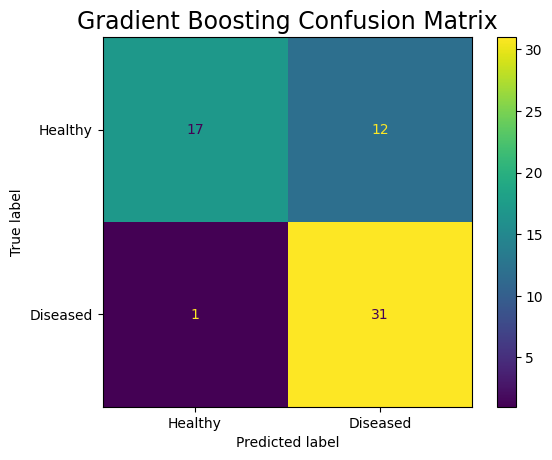

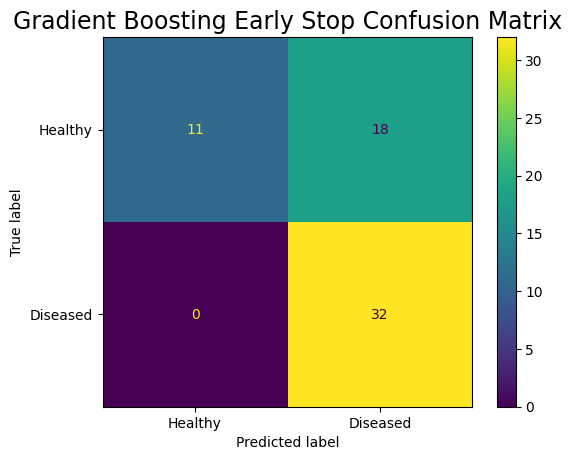

In [29]:
# Plot confusion matricies for each model

for model in list(models_dict.keys()):
    plot_confusion(models_dict[model], X_test, y_test, name=model, safe=True, X_train=X_train, y_train=y_train)

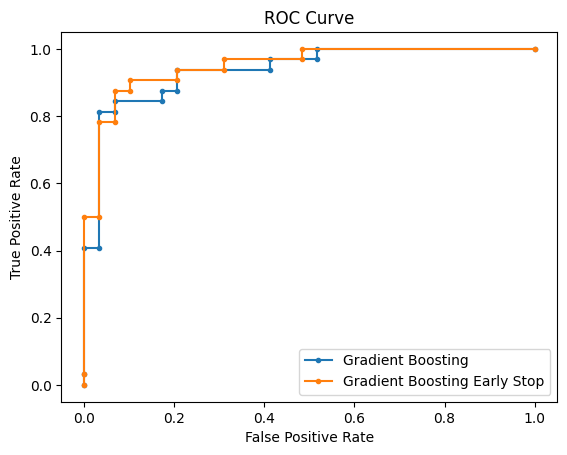

In [30]:
# Plot ROC curves for models using dictionary

plot_roc(models_dict, X_test, y_test)

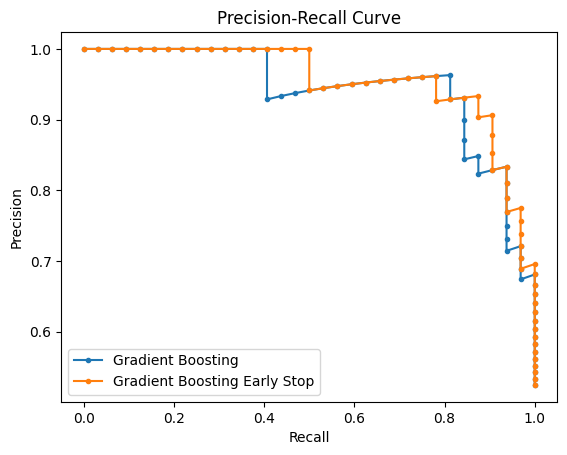

In [31]:
# Plot precision-recall curves for models using dictionary

plot_pr(models_dict, X_test, y_test)

**Choices to try adjusting when testing the models**
* do not remove as much data
* use binary version of oldpeak
* onehot encode features currently ordinally pre-encoded